# Action 2 : 기여도 분석 및 시뮬레이션을 통한 예산 최적화
- 도메인 기반 및 Markov Chain의 제거 효과를 이용한 기여도 분석을 통해 채널 기여도 파악
- 도메인 기반 및 모델 기반 기여도 분석을 통해 캠페인 기여도 파악 및 시뮬레이션 진행

---

---

# 채널 기여도 분석
- 전자 제품 이커머스 회사는 채널을 통해 광고를 집행하고 있다고 가정
    - 채널 : Facebook, Instagram, Paid Search, Online Video, Online Display Channel

## 데이터 살펴보기

In [1]:
df = pd.read_csv('data/attribution_data.csv')

print(df.shape)
df.head(3)

(586737, 6)


,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [3]:
for col in df.columns:
    print(f"{col} : Unique Classes {df[col].nunique()}")

cookie : Unique Classes 240108
time : Unique Classes 485110
interaction : Unique Classes 2
conversion : Unique Classes 2
conversion_value : Unique Classes 11
channel : Unique Classes 5


In [4]:
print(f"Channel : {df.channel.unique()}")
print(f"Conversion Value : {df.conversion_value.unique()}")

Channel : ['Instagram' 'Online Display' 'Paid Search' 'Facebook' 'Online Video']
Conversion Value : [0.  6.5 8.  6.  7.5 7.  5.  4.5 5.5 8.5 4. ]


In [5]:
df.interaction.value_counts()

impression    569098
conversion     17639
Name: interaction, dtype: int64

In [6]:
df.channel.value_counts()

Facebook          175741
Paid Search       151440
Online Video      113302
Instagram          75201
Online Display     71053
Name: channel, dtype: int64

In [7]:
# 쿠키(유저)별 노출된 Unique한 채널 수 
channel_per_cookie = df.groupby('cookie')['channel'].nunique().reset_index()
channel_per_cookie[:5]

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [8]:
# Unique 노출 채널 수별 쿠키 수
channel_per_cookie.groupby('channel').count()

,cookie
channel,
1,183020
2,45964
3,9549
4,1473
5,102


---

---

## 도메인 기반 기여도 분석
- Last, First, Linear Interaction Attribution Model

In [9]:
# 쿠키 및 시간에 대해 데이터 정렬
df['timestamp'] = pd.to_datetime(df['time'])
df.sort_values(['cookie', 'timestamp'], inplace=True)

df.head(2)

,cookie,time,interaction,conversion,conversion_value,channel,timestamp
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram,2018-07-03 13:02:11+00:00
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display,2018-07-17 19:15:07+00:00


### Last Interaction Attribution Model
- 마지막으로 노출/클릭된 채널의 기여도를 100%로 가정

In [10]:
# 쿠키별 마지막 데이터에 대해서만 추출
last_interaction_df = df.drop_duplicates('cookie', keep='last')[['cookie', 'channel', 'conversion', 'conversion_value']]
last_interaction_df.head(2)

,cookie,channel,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,Online Display,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,Paid Search,0,0.0


In [11]:
# 전환이 된 마지막 채널 추출
conversion_interaction = last_interaction_df.loc[last_interaction_df.conversion == 1]

print(f"전환 수 : {len(conversion_interaction)}")
conversion_interaction.head(2)

전환 수 : 17639


,cookie,channel,conversion,conversion_value
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,6.5
23,00090n9EBBEkA000C7Cik999D,Facebook,1,8.0


In [12]:
# 전환 데이터셋의 모든 쿠기는 서로 독립
conversion_interaction.cookie.nunique()

17639

In [13]:
sort_datas = conversion_interaction.groupby('channel')[['conversion', 'conversion_value']].agg(['count', 'sum'])

In [14]:
last_interaction_attr = pd.DataFrame(
    {
    'attribution_cnt': sort_datas[('conversion', 'count')] ,
    'attribution_sum': sort_datas[('conversion_value', 'sum')]
    }, index=sort_datas.index)

last_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,5301,33143.5
Instagram,2244,14039.5
Online Display,2139,13298.5
Online Video,3408,21418.0
Paid Search,4547,28331.5


---

### First Interaction Attribution Model
- 처음으로 노출/클릭된 채널의 기여도를 100%로 가정

In [15]:
first_interaction_df = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel', 'conversion', 'conversion_value']]
first_interaction_df.head(2)

,cookie,channel,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram,0,0.0
4,0000nACkD9nFkBBDECD3ki00E,Paid Search,0,0.0


In [16]:
first_interaction_conversion = (
    first_interaction_df[['cookie', 'channel']]
    .merge(conversion_interaction[['cookie', 'conversion', 'conversion_value']], on='cookie')
)

first_interaction_conversion.head(2)

,cookie,channel,conversion,conversion_value
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,6.5
1,00090n9EBBEkA000C7Cik999D,Facebook,1,8.0


In [17]:
sort_datas = first_interaction_conversion.groupby('channel')[['conversion', 'conversion_value']].agg(['count', 'sum'])

In [18]:
first_interaction_attr = pd.DataFrame(
    {
    'attribution_cnt': sort_datas[('conversion', 'count')] ,
    'attribution_sum': sort_datas[('conversion_value', 'sum')]
    }, index=sort_datas.index)

first_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,5177,32283.0
Instagram,2329,14579.5
Online Display,2160,13419.0
Online Video,3216,20225.5
Paid Search,4757,29724.0


---

### Linear Interaction Attribution Model
- 전환 과정 중 발생한 모든 채널의 기여도가 동일하다고 가정

In [19]:
# 유저 및 채널에 대해 중복되는 데이터 제거
unique_cookie_channel = df.drop_duplicates(['cookie', 'channel'], keep='last')[['cookie', 'channel']]

In [20]:
# 쿠키별 노출된 채널 및 채널 수
cookie_channel_df = unique_cookie_channel.merge(
    channel_per_cookie, on='cookie'
).rename({'channel_x': 'channel', 'channel_y': 'channel_cnt'}, axis=1)

cookie_channel_df.head(2)

,cookie,channel,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,Instagram,2
1,00000FkCnDfDDf0iC97iC703B,Online Display,2


In [21]:
conversion_interaction.head(1)

,cookie,channel,conversion,conversion_value
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,6.5


In [22]:
linear_interaction_conversion = cookie_channel_df.merge(
    conversion_interaction[['cookie', 'conversion', 'conversion_value']], on='cookie'
)

linear_interaction_conversion.head(2)

,cookie,channel,channel_cnt,conversion,conversion_value
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,6.5
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,8.0


In [23]:
linear_interaction_conversion['linear_cnv'] = (
    linear_interaction_conversion.conversion / linear_interaction_conversion.channel_cnt
)

linear_interaction_conversion['linear_val'] = (
    linear_interaction_conversion.conversion_value / linear_interaction_conversion.channel_cnt
)

linear_interaction_conversion.head()

,cookie,channel,channel_cnt,conversion,conversion_value,linear_cnv,linear_val
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,6.5,1.0,6.50
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,8.0,1.0,8.00
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1,1,6.0,1.0,6.00
3,000hCBnCB7oi7ADAEnEBCnBEE,Instagram,2,1,6.5,0.5,3.25
4,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,2,1,6.5,0.5,3.25


In [24]:
sort_datas = linear_interaction_conversion.groupby("channel")[['linear_cnv', 'linear_val']].sum()

In [25]:
linear_interaction_attr = pd.DataFrame(
    {
        'attribution_cnt': sort_datas['linear_cnv'],
        'attribution_sum': sort_datas['linear_val']
    }, index=sort_datas.index
)

linear_interaction_attr

,attribution_cnt,attribution_sum
channel,,
Facebook,4947.600000,30910.008333
Instagram,2627.100000,16442.758333
Online Display,2143.600000,13324.466667
Online Video,3192.183333,20066.175000
Paid Search,4728.516667,29487.591667


---

### 도메인 기반 기여도 분석 모델 비교

In [26]:
import seaborn as sns


sns.set_theme(style="whitegrid", palette="Paired")

In [27]:
last_interaction_attr['method'] = 'last'
first_interaction_attr['method'] = 'first'
linear_interaction_attr['method'] = 'linear'

In [28]:
domain_attr = pd.concat([last_interaction_attr, first_interaction_attr, linear_interaction_attr])
domain_attr['attribution_rate'] = domain_attr['attribution_sum'] / domain_attr['attribution_cnt']

domain_attr

,attribution_cnt,attribution_sum,method,attribution_rate
channel,,,,
Facebook,5301.000000,33143.500000,last,6.252311
Instagram,2244.000000,14039.500000,last,6.256462
Online Display,2139.000000,13298.500000,last,6.217158
Online Video,3408.000000,21418.000000,last,6.284624
Paid Search,4547.000000,28331.500000,last,6.230812
Facebook,5177.000000,32283.000000,first,6.235851
Instagram,2329.000000,14579.500000,first,6.259983
Online Display,2160.000000,13419.000000,first,6.212500
Online Video,3216.000000,20225.500000,first,6.289024


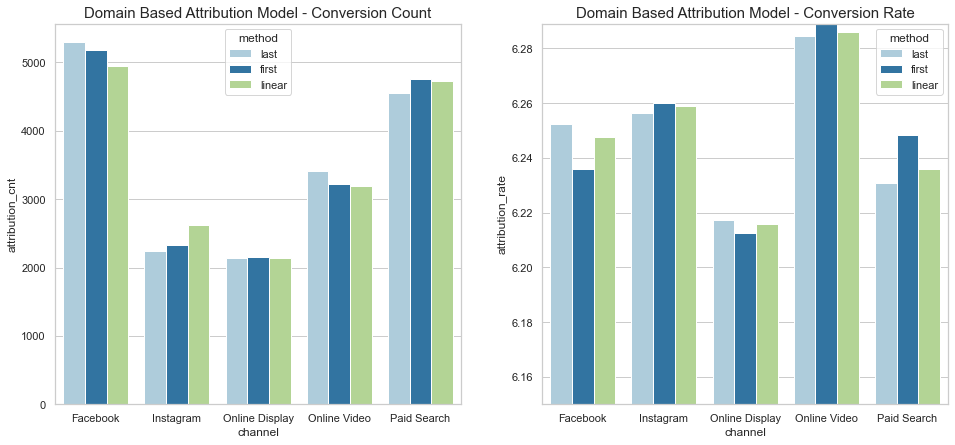

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax1 = sns.barplot(x=domain_attr.index, y=domain_attr.attribution_cnt, hue=domain_attr.method, ax=axes[0])
ax1.set_title("Domain Based Attribution Model - Conversion Count", size=15)

ax2 = sns.barplot(x=domain_attr.index, y=domain_attr.attribution_rate, hue=domain_attr.method, ax=axes[1])
ax2.set_title("Domain Based Attribution Model - Conversion Rate", size=15)
ax2.set_ylim(6.15, domain_attr.attribution_rate.max())

plt.show()

- 페이스북은 last interaction 일 때, 전환율이 가장 높았음 : 유저들이 전환을 하기 직전에 마지막으로 본 채널이 페이스북이 더 많았음
- paid search 는 검색을 한 뒤에, 그 다음에 페이스북을 보든지, 인스타를 보든지해서 전환이 일어나는 것 같음
    - last에서 낮았는데, first, linear일 때가 높기에 
- 인스타는 first, linear로 봤을 때 기여도가 높아지는 경향 : 인스타를 여러 채널을 접했을 때, 그 중 하나가 인스타일 확률이 있나보다 그래서 채널이 여러개일 때 기여도가 높아지는 경향이 있음

- Online Video의 전환수에 대한 기여도는 3위이지만 전환당 전환가치의 비율은 가장 높음

---

---

## Markov Chain을 통한 기여도 분석

### 각 채널에 대한 전이 확률

In [30]:
# 쿠키별 접한 채널 list
cookie_paths = df.groupby('cookie')['channel'].agg(lambda x: x.unique().tolist()).reset_index()
cookie_paths.head(2)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]


In [31]:
# 유저별 접한 채널과 전환여부 merge
cookie_paths = pd.merge(cookie_paths, last_interaction_df[['cookie', 'conversion']], how='left', on='cookie')
cookie_paths.head(2)

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0


In [32]:
# 해당 데이터셋의 전체 전환율
print(f"Base Conversion Rate : {cookie_paths.conversion.value_counts(normalize=True)[1].round(4)}")

Base Conversion Rate : 0.0735


#### Markov Chain의 State 생성
- Start : 첫 시작 > 각 쿠키별로 부여
- Instagram, Paid Search, Facebook, Online Video, Online Display
- Conversion : 전환 성공 / Null : 전환 실패

In [33]:
# 시작, 최종 State 추가
cookie_paths['paths'] = (
    cookie_paths.apply(
        lambda x: ['Start'] + x.channel + ['Null']
            if x.conversion == 0
            else ['Start'] + x.channel + ['Conversion'],
        axis=1
    )
)

cookie_paths.head(2)

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"


#### 모든 쿠키의 sequential path에 대해 유니크한 State 추출

In [34]:
unique_channels = set(channel for path in cookie_paths['paths'] for channel in path)
unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

#### 전이 가능성 있는 모든 경우의 수 생성 및 초기화
- 현재 State에서 다음 State로 간 것에 대한 count를 위해 초기값 0 설정

In [35]:
transition_states = {x + '>' + y: 0 for x in unique_channels for y in unique_channels}

#### 마지막 State를 제외한 모든 경우의 수에 대한 빈도 수 계산

In [36]:
# 유니크한 State를 돌면서
for state in unique_channels:
    # 마지막 State를 제외한 다음 State가 있는 State만 계산
    if state not in ['Conversion', 'Null']:
        # 쿠키별 이동 경로를 돌면서
        for path in cookie_paths['paths']:
            # 해당 이동 경로에 선택한 State가 있다면
            if state in path:
                # 이동 경로에서 선택한 State의 인덱스를 추출
                indices = [i for i, s in enumerate(path) if state in s]
                # 인덱스를 돌면서
                for col in indices:
                    # 선택한 State와 다음 State의 전이 관계에 1씩 더해줌
                    key = path[col] + '>' + path[col+1]
                    transition_states[key] += 1

#### 전이확률을 저장할 defaultdict 생성

In [37]:
from collections import defaultdict

In [38]:
trans_prob = defaultdict(dict)
for state in unique_channels:
    next_states_from_state = [s for s in transition_states if state + '>' in s]
    
    counter = 0
    for next_state in next_states_from_state:
        if transition_states[next_state] > 0:
            counter += transition_states[next_state]
            
    for next_state in next_states_from_state:
        if transition_states[next_state] > 0:
            state_prob = float((transition_states[next_state])) / float(counter)
            trans_prob[next_state] = state_prob

In [39]:
trans_prob

defaultdict(dict,
            {'Online Display>Instagram': 0.02936344005257722,
             'Online Display>Paid Search': 0.09238569148436766,
             'Online Display>Online Video': 0.017298845178856444,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Null': 0.7566425687728852,
             'Online Display>Conversion': 0.05032391324758239,
             'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Null': 0.6297861157158452,
             'Instagram>Conversion': 0.057979218048760765,
             'Start>Online Display': 0.14264414346877238,
             'Start>Instagram': 0.11918803205224315,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Online Video': 0.14236093757808985,
             'Start>Facebook': 0.278408

### 전이확률행렬 (Transition Probability Matrix) 생성

In [48]:
trans_matrix = pd.DataFrame()
for channel in unique_channels:
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00
    
    trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

In [49]:
trans_matrix

,Online Display,Instagram,Start,Paid Search,Online Video,Facebook,Null,Conversion
Online Display,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paid Search,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Video,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Conversion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### State에 대한 전이확률을 현재와 다음 State에 대입

In [50]:
for k, v in trans_prob.items():
    origin, destination = k.split('>')
    trans_matrix.at[origin, destination] = v

In [51]:
trans_matrix

,Online Display,Instagram,Start,Paid Search,Online Video,Facebook,Null,Conversion
Online Display,0.000000,0.029363,0.0,0.092386,0.017299,0.053986,0.756643,0.050324
Instagram,0.023531,0.000000,0.0,0.045809,0.024118,0.218777,0.629786,0.057979
Start,0.142644,0.119188,0.0,0.317399,0.142361,0.278408,0.000000,0.000000
Paid Search,0.048053,0.034196,0.0,0.000000,0.029221,0.064442,0.770779,0.053309
Online Video,0.018920,0.031908,0.0,0.047947,0.000000,0.059323,0.763757,0.078146
Facebook,0.024352,0.173072,0.0,0.050655,0.025577,0.000000,0.673123,0.053220
Null,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
Conversion,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000


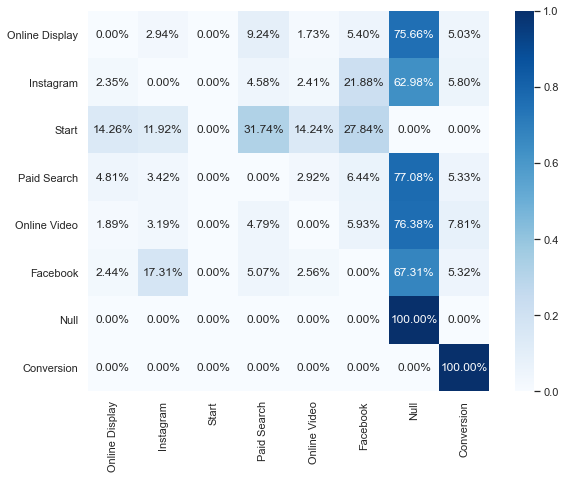

In [52]:
ax = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap="Blues")
ax.figure.set_size_inches(9, 7)

- Paid Search 는 77% Null로 가고, Instagram은 62% Null로 감
- Instagram에서 Null을 제외하면 21% 페이스북으로 감 > 인스타에서는 페이스북으로 가는 전이형태가 많이 발생
- Start는 Paid Search로의 전이가 가장 높음